## Visual Transformer for Skin Cancer Detection

In [1]:
import evaluate
import torch
from transformers import ViTForImageClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import ViTImageProcessor
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import datasets
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import h5py
import cv2
from PIL import Image
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import safetensors.torch
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import random
import os

2024-12-11 09:28:14.630907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 09:28:15.691079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733927296.059768 3120402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733927296.110425 3120402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 09:28:16.750617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
#loading data
BASE_PATH = "isic-2024-challenge"
training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')

# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
df = df.ffill()
display(df.head(2))

# Testing
testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))

/scratch/1497617.1.neuro-autonomy-pub/ipykernel_3120402/665367782.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


In [3]:
from sklearn.utils.class_weight import compute_class_weight
#Handle Class Imbalance
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)
seed = 1

# Desired distribution
N, T = 0.80, 0.20  # for a 70:30 split

# Current counts
neg_count = df.query("target == 0").shape[0]
pos_count = df.query("target == 1").shape[0]

# Calculate sampling fractions
pos_sample = 1.0
neg_sample = (N * pos_count) / (T * neg_count)

# Sampling
positive_df = df.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = df.query("target==1").sample(frac=pos_sample, replace=False, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    80.0
1    20.0
Name: proportion, dtype: float64

Class Weights: {0: 0.625, 1: 2.5}


In [74]:
from sklearn.model_selection import StratifiedGroupKFold
def get_k_data(df, k):
    

    # Reset index to ensure a continuous index
    df = df.reset_index(drop=True)
    df["fold"] = -1

    # Set up the StratifiedGroupKFold with 5 splits
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)

    # Assign fold numbers to each data point
    for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
        df.loc[validation_idx, "fold"] = int(i)
    # Define the train, validation, and test sets
    # Use fold 0 for test, fold 1 for validation, and remaining folds for training
    #change these for each trial, testing all test_fold = [1,2,3,4,5]
    test_fold = k
    valid_fold = random.choice([num for num in range(5) if num != k])

    # Create the training, validation, and test sets
    training_df = df.query(f"fold != {valid_fold} and fold != {test_fold}")
    validation_df = df.query(f"fold == {valid_fold}")
    test_df = df.query(f"fold == {test_fold}")

    # Print the number of samples in each set
    print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)} | Num Test: {len(test_df)}")
    return training_df, validation_df, test_df


In [75]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=processor.image_mean, std=processor.image_std),
    ])

def preprocess_images(example):
        byte_string = training_validation_hdf5[example["isic_id"]][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1]
        image = Image.fromarray(image)
        example['pixel_values'] = transform(image)
        return example

def get_datasets(df, k):
        training_df,validation_df,test_df = get_k_data(df, k)

        ds_training = datasets.Dataset.from_pandas(pd.DataFrame(data=training_df))
        ds_valid = datasets.Dataset.from_pandas(pd.DataFrame(data=validation_df))
        ds_test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_df))

        ds_training = ds_training.map(preprocess_images, batched=False)
        ds_valid = ds_valid.map(preprocess_images, batched=False)
        ds_test = ds_test.map(preprocess_images, batched=False)

        return ds_training, ds_valid, ds_test

In [6]:
#accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
     

In [80]:
def process_test_set(ds, num_samples):
    inputs = []
    labels = []
    for i in range(num_samples):
        byte_string = training_validation_hdf5[ds[i]["isic_id"]][()]
        nparr = np.frombuffer(byte_string, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1]
        image = Image.fromarray(image)
        inputs.append(image)
        labels.append(ds[i]["target"]) 
    return inputs, labels

In [8]:
def test_validate(model, k):
    inputs, y_true = process_test_set(ds_test, len(ds_test))

    image_classifier = pipeline("image-classification", model ,image_processor=processor)
    predictions = image_classifier(inputs)
    #select highest labels
    predictions = [max(item, key=lambda x: x['score'])['label'] for item in predictions]
    #convert from LABEL_0, LABEL_1 to 0,1
    predictions = [1 if item == 'LABEL_1' else 0 for item in predictions]  
    accuracy = accuracy_score(y_true, predictions)
    #plot confusion matrix
    confusion_metric = evaluate.load("confusion_matrix")
    confusion_matrix = confusion_metric.compute(predictions=predictions, references=y_true)
    matrix = confusion_matrix['confusion_matrix']
    if 'labels' in confusion_matrix:
        labels = confusion_matrix['labels']
    else:
        labels = np.unique(predictions + y_true)
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.savefig("model_"+str(k)+".png")
    plt.show()  
    plot_roc_curve(y_true, predictions, k)
    return accuracy

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Num Train: 1190 | Num Valid: 328 | Num Test: 447


Map:   0%|          | 0/1190 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/447 [00:00<?, ? examples/s]

/projectnb/cs640grp/students/samwu/AgentO/.venv/lib64/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/scratch/1476028.1.l40s/ipykernel_2712838/4259806116.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


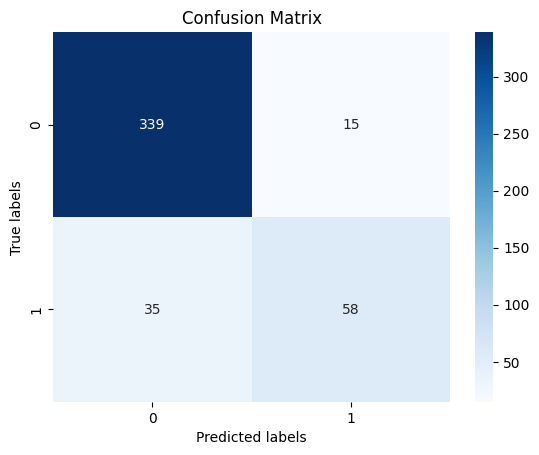

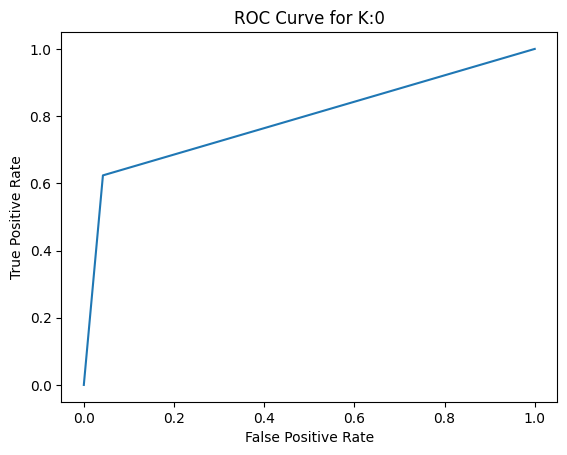

0.8881431767337807


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Num Train: 1190 | Num Valid: 447 | Num Test: 328


Map:   0%|          | 0/1190 [00:00<?, ? examples/s]

Map:   0%|          | 0/447 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

/projectnb/cs640grp/students/samwu/AgentO/.venv/lib64/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/scratch/1476028.1.l40s/ipykernel_2712838/4259806116.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [11]:
# Make sure its the right tensor types
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(example['pixel_values']) for example in batch])
    labels = torch.tensor([example['target'] for example in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

for k in range(5):
    model_name='google/vit-base-patch16-224-in21k'
    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTForImageClassification.from_pretrained(model_name)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ds_training, ds_valid, ds_test = get_datasets(df, k)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./vit-finetuned-agent0',
        metric_for_best_model = "accuracy",
        per_device_train_batch_size=64,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=5,
        logging_dir='./logs',
        logging_steps=10,
        load_best_model_at_end=True,
        remove_unused_columns=False,
        no_cuda=False,
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=3,  # Number of evaluations with no improvement before stopping
        early_stopping_threshold=0.01  # Minimum change to qualify as an improvement
        )

    # Initialize the Trainer
    trainer = Trainer(
        model=model.to(device),  # Explicitly move model to GPU (if available)
        args=training_args,
        train_dataset=ds_training,
        eval_dataset=ds_valid,
        data_collator=collate_fn,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]  # Add early stopping callback
    )
    #train da model
    trainer.train()
    # Save da fine-tuned model
    trainer.save_model('vit-finetuned-agentO_'+str(k))
    trainer.eval_dataset=ds_test
    trainer.evaluate()
    print(test_validate(model, k))

# Final Stuff

In [4]:
from pathlib import Path

In [5]:
def image_to_byte_string(image_path):
    #useful helper
    image_path = Path(image_path)  
    with image_path.open('rb') as f:
        byte_string = f.read()
    return byte_string
def process_test_set(ds, file_loc):
    inputs = []
    labels = []
    for i in range(len(ds)):
        #byte_string = training_validation_hdf5[ds[i]["isic_id"]][()] # SAM PREV LINE
        img_path = os.path.join(BASE_PATH, file_loc, (str(ds[i]["id"]) + '.jpg'))
        byte_string = image_to_byte_string(img_path)
        nparr = np.frombuffer(byte_string, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1]
        image = Image.fromarray(image)
        inputs.append(image)
        labels.append(ds[i]["target"]) 
    return inputs, labels
def make_csv(test_predictions):
    df = pd.DataFrame({'id':[], 'target_0':[], 'target_1':[]})
    for i in range(len(test_predictions)):
        new_row = {'id': i, 'target_0': test_predictions[i][0]['score'], 'target_1': test_predictions[i][1]['score']}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    return df

In [6]:
MODELS_SAVE_PATH = '../models/'
#BASE_PATH = "../data/isic-2024-challenge"
BASE_PATH = '/projectnb/cs640grp/materials/ISIC-2024_CS640'

In [7]:
file_dict = {
    "sample_sub": "submission.csv",
    "test_images": "test_image",
    "test_metadata": "test_metadata.csv",
    "train_images": "train_image",
    "train_metadata": "train_metadata.csv"
}
for key in file_dict.keys():
    path = os.path.join(os.getcwd(), BASE_PATH, file_dict[key])
    path = os.path.normpath(path)
    file_dict[key] = path
file_dict


{'sample_sub': '/projectnb/cs640grp/materials/ISIC-2024_CS640/submission.csv',
 'test_images': '/projectnb/cs640grp/materials/ISIC-2024_CS640/test_image',
 'test_metadata': '/projectnb/cs640grp/materials/ISIC-2024_CS640/test_metadata.csv',
 'train_images': '/projectnb/cs640grp/materials/ISIC-2024_CS640/train_image',
 'train_metadata': '/projectnb/cs640grp/materials/ISIC-2024_CS640/train_metadata.csv'}

In [8]:
full_test_df = pd.read_csv(file_dict['test_metadata'])
full_test_ds = datasets.Dataset.from_pandas(pd.DataFrame(data=full_test_df))

In [17]:
full_test_df.head()

,id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,NaN,30.0,male,upper extremity,2.52,3D: white,20.739760,17.346250,23.604410,...,2.013941,9.113276,0.793600,1.368380,3.130576,0.392593,85,-352.631000,1024.501000,21.431270
1,1,NaN,75.0,male,upper extremity,2.63,3D: white,21.498600,17.128050,26.919320,...,3.554856,6.968501,1.322546,2.980941,2.610491,0.342857,150,317.008100,1296.112000,85.410520
2,2,NaN,30.0,male,lower extremity,18.31,3D: XP,21.261867,15.949655,36.927874,...,3.685572,67.921989,1.323685,1.912243,3.394053,0.385400,145,-185.792664,680.623718,-21.791901
3,3,NaN,45.0,female,upper extremity,3.55,3D: XP,21.087236,15.657230,31.419333,...,2.082827,10.582854,0.691356,1.349557,1.570233,0.250000,155,443.583984,1213.412598,39.409851
4,4,NaN,55.0,male,anterior torso,7.06,3D: white,22.121790,14.444030,30.308130,...,3.691011,19.856620,0.989644,3.126280,2.467318,0.227068,70,-162.127900,1043.082000,-44.661830


In [9]:
#~3min
inputs_test, y_true_test = process_test_set(full_test_ds, "test_image")

In [10]:
model = ViTForImageClassification.from_pretrained('vit-finetuned-agentO_4')
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
image_classifier = pipeline("image-classification", model,image_processor=processor, device=0 if torch.cuda.is_available() else -1)

test_predictions = image_classifier(inputs_test)

In [11]:
def make_csv(test_predictions):
    df = pd.DataFrame({'id':[], 'target_0':[], 'target_1':[]})
    for i in range(len(test_predictions)):
        new_row = {'id': i, 'target_0': test_predictions[i][0]['score'], 'target_1': test_predictions[i][1]['score']}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    return df

final_df = make_csv(test_predictions)

In [ ]:
final_df.to_csv("vit_test_probabilities_final.csv", index = False)

# For Train images

In [6]:
full_train_df = pd.read_csv(file_dict['train_metadata'])
full_train_df = datasets.Dataset.from_pandas(pd.DataFrame(data=full_train_df))

In [7]:
#~3min
inputs_train, y_true_train = process_test_set(full_train_df, "train_image")

In [15]:
model = ViTForImageClassification.from_pretrained('vit-finetuned-agentO_0')
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
image_classifier = pipeline("image-classification", model,image_processor=processor, device=0 if torch.cuda.is_available() else -1)
train_predictions = image_classifier(inputs_train)

In [17]:
final_df = make_csv(train_predictions)
final_df.to_csv("vit_train_probabilities_0.csv", index = False)

# plot ROC curve

In [67]:
def plot_roc_curve(true_y, y_prob, k):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve for K:"+str(k))
    plt.savefig("ROC Curve for K:"+str(k)+".png")
    plt.show()

In [68]:
model = ViTForImageClassification.from_pretrained('vit-finetuned-agentO_0')
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [76]:
ds_training, ds_valid, ds_test = get_datasets(df, 0)

Parameter 'function'=<function preprocess_images at 0x14b0df457100> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


# Num Train: 1097 | Num Valid: 421 | Num Test: 447


Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

Map:   0%|          | 0/447 [00:00<?, ? examples/s]

In [83]:
inputs_train, y_true_train = process_test_set(ds_test, len(ds_test))
image_classifier = pipeline("image-classification", model ,image_processor=processor, device=0 if torch.cuda.is_available() else -1 )

In [85]:
predictions = image_classifier(inputs_train)
#select highest labels
predictions = [max(item, key=lambda x: x['score'])['label'] for item in predictions]
#convert from LABEL_0, LABEL_1 to 0,1
predictions = [1 if item == 'LABEL_1' else 0 for item in predictions]  

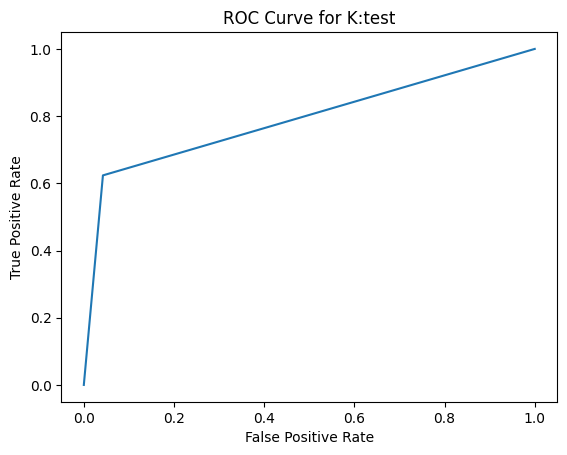

In [86]:
plot_roc_curve(y_true_train, predictions, "test")

In [87]:
roc_auc_score(y_true_train, predictions)


0.7906415163112812